In [10]:
import numpy as np
import os
import random
import glob
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import fetch_covtype
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.io import arff
import sklearn as sk
import time
from sklearn.datasets import fetch_openml

In [11]:
%run 'common.ipynb'

In [67]:
def get_anomaly_X_y_from_csv(csv_file, main_labels, target_column, normal_target, output_folder):
    df=pd.read_csv(os.path.join(output_folder, csv_file),usecols=main_labels)
    df=df.fillna(0)
    anomaly_or_not=[]
    for i in df[target_column]: #it changes the normal label to "1" and the anomaly tag to "0" for use in the machine learning algorithm
        if i == normal_target:
            anomaly_or_not.append(1)
        else:
            anomaly_or_not.append(0)           
    df[target_column]=anomaly_or_not

    # y = df[target_column].values
    # del df[target_column]
    # X = df.values
    y_df = df[target_column]
    X_df = df.drop(columns=[target_column])
    
    # X = np.float32(X)
    # X[np.isnan(X)] = 0
    # X[np.isinf(X)] = 0
    # print('X', type(X), X)
    # print('y', type(y), y)
    return (X_df, y_df, df)

def get_kdd_df():
    cols = open("./datasets/kdd/kddcup.names",'r').read()
    cols = [c[:c.index(':')] for c in cols.split('\n')[1:-1]]
    cols.append('attack')
    
    all_df = pd.read_csv("./datasets/kdd/corrected", names = cols)
    print(all_df['attack'].unique())
    # all_df['attack'] = all_df['attack'].apply(lambda r:TARGET_DICT[r[:-1]])
    
    main_labels = cols
    
    print('Normal class: ', all_df[TARGET_COLUMN].mode())
    print('Feature names: ', main_labels)
    return (all_df, main_labels)

def get_covtype_df():
    data = fetch_covtype(as_frame=True)  # Set as_frame=True to get the data as a DataFrame
    X_data = data['data']
    y_data = data['target']
    
    # Combine features and target into one DataFrame
    all_df = pd.concat([X_data, y_data], axis=1)
    
    # Headers of column
    main_labels = data.feature_names[:]
    main_labels.append(TARGET_COLUMN)
    
    print('Normal class: ', all_df[TARGET_COLUMN].mode())
    print('Feature names: ', data.feature_names)
    return (all_df, main_labels)


def one_hot_encode(df, categorical_columns):
    # Initialize the OneHotEncoder
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Make a copy of the DataFrame to keep track of column order
    X_encoded = df.copy()
    
    # Loop over categorical columns to encode them one by one and retain column order
    for col in categorical_columns:
        # Get the position (index) of the categorical column in the original DataFrame
        col_position = X_encoded.columns.get_loc(col)
        
        # Reshape the column to a 2D array and apply one-hot encoding
        encoded_array = ohe.fit_transform(X_encoded[[col]])
        
        # Create a DataFrame for the one-hot encoded columns
        encoded_columns = ohe.get_feature_names_out([col])
        encoded_df = pd.DataFrame(encoded_array, columns=encoded_columns, index=X_encoded.index)
        
        # Drop the original categorical column from the DataFrame
        X_encoded = X_encoded.drop(columns=[col])
        
        # Insert the one-hot encoded columns back into the DataFrame at the original column's position
        for i, new_col in enumerate(encoded_columns):
            X_encoded.insert(col_position + i, new_col, encoded_df.iloc[:, i])
    
    # X_encoded now contains the one-hot encoded features in the correct positions
    print(list(X_encoded.columns))
    return (ohe, X_encoded)

In [ ]:
# Shared variables
OUTPUT_FOLDER = 'csv_files'
FEATURE_FOLDER = 'features'
TEST_COUNT = 500

In [54]:
# Dataset: KDD
# Define variables
# NORMAL_TARGET = 'normal'
# OUTPUT_FOLDER = 'csv_files'
# TARGET_COLUMN = 'attack'
# FEATURE_FOLDER = 'features'
# TEST_COUNT = 500

# # List of target class names
# TARGET_DICT = {
#     # 'back': 'dos',
#     # 'buffer_overflow': 'u2r',
#     # 'ftp_write': 'r2l',
#     # 'guess_passwd': 'r2l',
#     # 'imap': 'r2l',
#     # 'ipsweep': 'probe',
#     # 'land': 'dos',
#     # 'loadmodule': 'u2r',
#     # 'multihop': 'r2l',
#     # 'neptune': 'dos',
#     # 'nmap': 'probe',
#     # 'perl': 'u2r',
#     # 'phf': 'r2l',
#     # 'pod': 'dos',
#     # 'portsweep': 'probe',
#     # 'rootkit': 'u2r',
#     # 'satan': 'probe',
#     # 'smurf': 'dos',
#     # 'spy': 'r2l',
#     # 'teardrop': 'dos',
#     # 'warezclient': 'r2l',
#     # 'warezmaster': 'r2l',
#     # --
#     'normal':'normal',
#     'snmpgetattack': 'snmpgetattack',
#     'named': 'named',
#     'xlock': 'xlock',
#     'smurf': 'smurf',
#     'ipsweep': 'ipsweep',
#     'multihop':'multihop',
#     'xsnoop': 'xsnoop',
#     'sendmail': 'sendmail',
#     'guess_passwd': 'guess_passwd',
#     'saint': 'saint',
#     'buffer_overflow':'buffer_overflow',
#     'portsweep': 'portsweep',
#     'pod': 'pod',
#     'apache2': 'apache2',
#     'phf': 'phf',
#     'udpstorm': 'udpstorm',
#     'warezmaster':'warezmaster',
#     'perl': 'perl',
#     'satan': 'satan',
#     'xterm': 'xterm',
#     'mscan': 'mscan',
#     'processtable': 'processtable',
#     'ps': 'ps',
#     'nmap':'nmap',
#     'rootkit': 'rootkit',
#     'neptune': 'neptune',
#     'loadmodule': 'loadmodule',
#     'imap': 'imap',
#     'back': 'back',
#     'httptunnel': 'httptunnel',
#     'worm':'worm',
#     'mailbomb': 'mailbomb',
#     'ftp_write': 'ftp_write',
#     'teardrop': 'teardrop',
#     'land': 'land',
#     'sqlattack': 'sqlattack',
#     'snmpguess':'snmpguess',
# }

# INV_TARGET_DICT = {v: k for k, v in TARGET_DICT.items()}

# List of numerical columns (these are to be standardized)
NUMERICAL_COLUMNS = ['duration', 'src_bytes', 'dst_bytes',
                     'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'num_compromised', 
                     'root_shell', 'su_attempted', 'num_file_creations', 'num_shells', 'num_access_files', 
                     'num_outbound_cmds', 'count', 'srv_count', 'serror_rate', 
                     'rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
                     'dst_host_srv_count', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate']
# List of categorical columns (these are to be one hot encoded)
CATEGORICAL_COLUMNS = ['protocol_type', 'service', 'flag']
# List of ordinal columns (these are to be label encoded)
ORDINAL_COLUMNS = []

In [5]:
# Dataset covertype
# Define variables
NORMAL_TARGET = 2
TARGET_COLUMN = 'Cover_Type'

# List of target class names
TARGET_DICT = {
    1: "Spruce-Fir",
    2: "LodgepolePine",
    3: "PonderosaPine",
    4: "CottonwoodWillow",
    5: "Aspen",
    6: "DouglasFir",
    7: "Krummholz"
}

INV_TARGET_DICT = {
    "Spruce-Fir": 1,
    "LodgepolePine": 2,
    "PonderosaPine": 3,
    "CottonwoodWillow": 4,
    "Aspen": 5,
    "DouglasFir": 6,
    "Krummholz": 7,
}

# List of numerical columns (these are to be standardized)
NUMERICAL_COLUMNS = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 
                     'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                     'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
                     'Horizontal_Distance_To_Fire_Points']
# List of categorical columns (these are to be one hot encoded)
CATEGORICAL_COLUMNS = []
# List of ordinal columns (these are to be label encoded)
ORDINAL_COLUMNS = []

In [55]:
# Create a folder to save the CSVs
remove_files_from_directory(OUTPUT_FOLDER)
remove_files_from_directory(FEATURE_FOLDER)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(FEATURE_FOLDER, exist_ok=True)

All files in csv_files have been removed.
All files in features have been removed.


In [ ]:
# Dataset covertype
all_df, main_labels = get_covtype_df()
all_df.head()

In [56]:
# Dataset KDD
all_df, main_labels = get_kdd_df()

encoder = LabelEncoder()
all_df['attack'] = all_df['attack'].str[:-1]
all_df['attack'] = encoder.fit_transform(all_df['attack'])
TARGET_DICT = {index: label for index, label in enumerate(encoder.classes_)}
INV_TARGET_DICT = {v: k for k, v in TARGET_DICT.items()}
NORMAL_TARGET = INV_TARGET_DICT['normal']
print('NORMAL_TARGET', NORMAL_TARGET)
print('TARGET_DICT', TARGET_DICT)

ohe, all_df = one_hot_encode(all_df, CATEGORICAL_COLUMNS)
main_lables = all_df.columns
print('main_labels', main_labels)
    
all_df.head()

['normal.' 'snmpgetattack.' 'named.' 'xlock.' 'smurf.' 'ipsweep.'
 'multihop.' 'xsnoop.' 'sendmail.' 'guess_passwd.' 'saint.'
 'buffer_overflow.' 'portsweep.' 'pod.' 'apache2.' 'phf.' 'udpstorm.'
 'warezmaster.' 'perl.' 'satan.' 'xterm.' 'mscan.' 'processtable.' 'ps.'
 'nmap.' 'rootkit.' 'neptune.' 'loadmodule.' 'imap.' 'back.' 'httptunnel.'
 'worm.' 'mailbomb.' 'ftp_write.' 'teardrop.' 'land.' 'sqlattack.'
 'snmpguess.']
Normal class:  0    smurf.
Name: attack, dtype: object
Feature names:  ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,16
1,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,16
2,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,16
3,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,28
4,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,28


In [57]:
all_df.to_csv('all_data.csv' ,index = False)

In [58]:
# Get X and y from all_df
X_df = all_df.drop(columns=[TARGET_COLUMN])
y_df = all_df[TARGET_COLUMN]

# Split the data into training and test sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_df, y_df, test_size=0.2, random_state=42)
print(X_train_df.shape, X_test_df.shape, y_train_df.shape, y_test_df.shape)

(248823, 117) (62206, 117) (248823,) (62206,)


In [59]:
# Concatenate X_train and y_train along the columns (axis=1)
X_y_train_df = pd.concat([X_train_df, y_train_df], axis=1)
X_y_train_df.head()

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
147391,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,231,1.00,0.00,0.02,0.01,0.0,0.0,0.0,0.0,16
107622,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17,0.07,0.06,0.00,0.00,0.0,0.0,1.0,1.0,14
53448,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,27
3099,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,27
208489,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,27


In [60]:
# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the numeric columns
X_train_scaled_df = X_train_df.copy()
X_train_scaled_df[NUMERICAL_COLUMNS] = scaler.fit_transform(X_train_scaled_df[NUMERICAL_COLUMNS])
# print('X_train_scaled_df', X_train_scaled_df)

# Use the same scaler to transform X_test
X_test_scaled_df = X_test_df.copy()
X_test_scaled_df[NUMERICAL_COLUMNS] = scaler.transform(X_test_scaled_df[NUMERICAL_COLUMNS])
# print('X_test_scaled_df', X_test_scaled_df)

In [61]:
le = LabelEncoder()

X_encoded_transformed = y_train_df.copy()

# Loop through each ordinal column and apply LabelEncoder
for col in ORDINAL_COLUMNS:
    # Fit and transform the ordinal column
    X_encoded_transformed[col] = le.fit_transform(y_train_df[col])

# X_encoded_transformed now contains the label-encoded ordinal columns
X_encoded_transformed.head()

147391    16
107622    14
53448     27
3099      27
208489    27
Name: attack, dtype: int64

In [65]:
# Loop through each cover type and create a dataset
benign=2359289
abnormal_type_counts = all_df[TARGET_COLUMN].value_counts()
abnormal_type_dict = abnormal_type_counts.to_dict()
print('abnormal_type_dict', abnormal_type_dict)

for label, name in TARGET_DICT.items():
# for label, name in [(1, "Spruce-Fir")]:
    if label == NORMAL_TARGET:
        continue
    a, b = 0, 0
    
    # Open the output file for writing
    output_path = os.path.join(OUTPUT_FOLDER, f"{name}.csv")
    with open(output_path, "w") as ths:
        ths.write(','.join(main_labels) + "\n")
        
        # Calculate the number of benign samples to include
        benign_num = int(benign / (abnormal_type_dict[label] * (7 / 3)))
        # print('name, benign_num', name, benign_num)

        # Read all_data.csv line by line
        with open("all_data.csv", "r") as file:
            for i, line in enumerate(file):
                if i == 0:
                    continue
                k = line.strip().split(",")  # Strip newline and split the line
                # if i%50 == 0:
                #     print('haha',k[-1], NORMAL_TARGET, type(k[-1]))
                # Check if the last column is the normal target
                if int(k[-1]) == NORMAL_TARGET:
                    rnd = random.randint(1, benign_num)
                    if rnd == 1:
                        ths.write(line)  # Write the original line directly
                        b += 1
                
                # Check if the last column matches the current label
                elif int(k[-1]) == label:
                    ths.write(line)  # Write the original line directly
                    a += 1

    print(f"{name}.csv created with {a + b} rows.")

print("All datasets created successfully!")

abnormal_type_dict {27: 164091, 16: 60593, 14: 58001, 28: 7741, 10: 5000, 4: 4367, 29: 2406, 25: 1633, 33: 1602, 1: 1098, 11: 1053, 0: 794, 21: 759, 24: 736, 20: 354, 7: 306, 5: 158, 19: 87, 15: 84, 2: 22, 12: 18, 13: 17, 26: 17, 22: 16, 23: 13, 37: 13, 31: 12, 35: 9, 8: 9, 36: 4, 3: 3, 9: 2, 17: 2, 32: 2, 34: 2, 18: 2, 30: 2, 6: 1}
apache2.csv created with 849 rows.
back.csv created with 1161 rows.
buffer_overflow.csv created with 25 rows.
ftp_write.csv created with 3 rows.
guess_passwd.csv created with 4635 rows.
httptunnel.csv created with 168 rows.
imap.csv created with 1 rows.
ipsweep.csv created with 318 rows.
land.csv created with 10 rows.
loadmodule.csv created with 2 rows.
mailbomb.csv created with 5303 rows.
mscan.csv created with 1117 rows.
multihop.csv created with 19 rows.
named.csv created with 17 rows.
neptune.csv created with 61577 rows.
nmap.csv created with 87 rows.
perl.csv created with 2 rows.
phf.csv created with 2 rows.
pod.csv created with 88 rows.
portsweep.csv 

In [42]:
# tdf = pd.read_csv('csv_files/portsweep.csv')
# tdf['attack'].unique()

array([16, 20])

csv_files ['portsweep.csv', 'processtable.csv', 'phf.csv', 'loadmodule.csv', 'httptunnel.csv', 'mscan.csv', 'buffer_overflow.csv', 'sendmail.csv', 'imap.csv', 'back.csv', 'smurf.csv', 'ipsweep.csv', 'udpstorm.csv', 'ps.csv', 'neptune.csv', 'teardrop.csv', 'pod.csv', 'warezmaster.csv', 'named.csv', 'xterm.csv', 'snmpguess.csv', 'xsnoop.csv', 'rootkit.csv', 'ftp_write.csv', 'snmpgetattack.csv', 'saint.csv', 'sqlattack.csv', 'land.csv', 'perl.csv', 'apache2.csv', 'guess_passwd.csv', 'xlock.csv', 'nmap.csv', 'worm.csv', 'multihop.csv', 'satan.csv', 'mailbomb.csv']
csv file portsweep.csv
   duration  protocol_type_icmp  protocol_type_tcp  protocol_type_udp  \
0         0                 0.0                1.0                0.0   
1         0                 0.0                1.0                0.0   
2         0                 0.0                1.0                0.0   
3         0                 0.0                1.0                0.0   
4         0                 0.0              

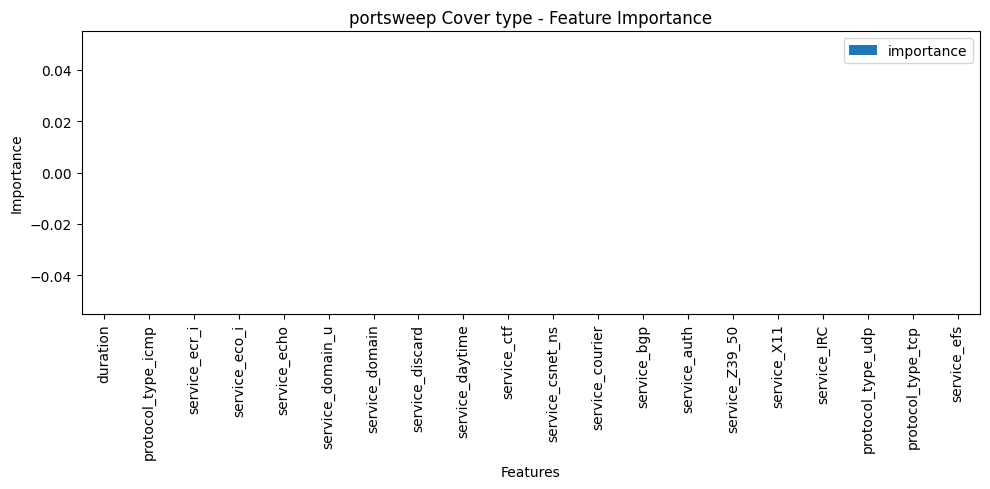

-----------------------------------------------------------------------------------------------




csv file processtable.csv
   duration  protocol_type_icmp  protocol_type_tcp  protocol_type_udp  \
0         0                 0.0                1.0                0.0   
1         0                 0.0                0.0                1.0   
2         0                 0.0                0.0                1.0   
3         0                 0.0                1.0                0.0   
4         0                 0.0                1.0                0.0   

   service_IRC  service_X11  service_Z39_50  service_auth  service_bgp  \
0          0.0          0.0             0.0           0.0          0.0   
1          0.0          0.0             0.0           0.0          0.0   
2          0.0          0.0             0.0           0.0          0.0   
3          0.0          0.0             0.0           0.0          0.0   
4          0.0          0.0             0.0           0.0        

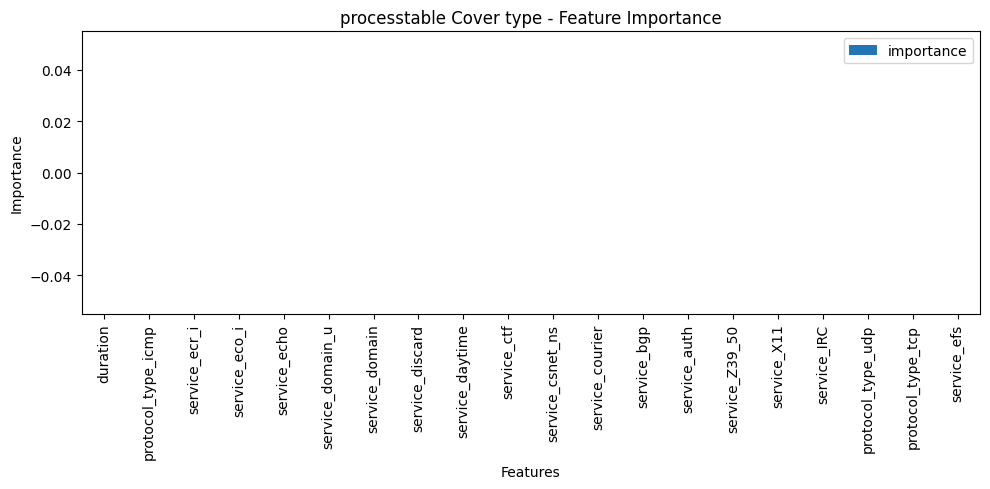

-----------------------------------------------------------------------------------------------




csv file phf.csv
   duration  protocol_type_icmp  protocol_type_tcp  protocol_type_udp  \
0         0                 0.0                1.0                0.0   
1         0                 0.0                1.0                0.0   

   service_IRC  service_X11  service_Z39_50  service_auth  service_bgp  \
0          0.0          0.0             0.0           0.0          0.0   
1          0.0          0.0             0.0           0.0          0.0   

   service_courier  ...  dst_host_srv_count  dst_host_same_srv_rate  \
0              0.0  ...                  17                    1.00   
1              0.0  ...                 227                    0.89   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.00                         0.06   
1                    0.02                         0.00   

   dst_host_srv_diff_host_rate  dst_host_serror_rat

ValueError: The number of classes has to be greater than one; got 1 class

In [66]:
seconds = time.time()

# CSV files names:
csv_files=os.listdir(OUTPUT_FOLDER)# It creates a list of file names in the "attacks" folder.
print('csv_files',csv_files)

ths = open("importance_list.csv", "w")
feature_importances = {}
SVMs = {}
for csv_file in csv_files:
    print('csv file', csv_file)
    
    X_df, y_df, df = get_anomaly_X_y_from_csv(csv_file, main_labels, TARGET_COLUMN, NORMAL_TARGET, OUTPUT_FOLDER)

    #computing the feature importances
    forest = sk.ensemble.RandomForestRegressor(n_estimators=250,random_state=0)
    forest.fit(X_df, y_df)
    importances = forest.feature_importances_
    label = csv_file.split(".")[0]
    print('importances', importances, label)
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    refclasscol=list(df.columns.values)
    impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})
    impor_bars = impor_bars.sort_values('importance',ascending=False)
    important_features = impor_bars['Features'].to_list()[:5]
    impor_bars = impor_bars.set_index('Features')
    print('important_features', important_features)
    feature_importances[label] = important_features

    X_scaled_df = X_df.copy()
    X_scaled_df[NUMERICAL_COLUMNS] = scaler.transform(X_scaled_df[NUMERICAL_COLUMNS])

    svm = SVC()
    X_train_class = df.iloc[:, df.columns.get_indexer(important_features)]
    # print('X_train_class', X_train_class)
    y_train_class = y_df
    # print('y_train_class', y_train_class)
    if len(y_train_class) > 0:  # Ensure there are samples for this class
        svm.fit(X_train_class, y_train_class)
    else:
        print(f'no data for {label}')
    SVMs[label] = svm

    
    plt.rcParams['figure.figsize'] = (10, 5)
    impor_bars.plot.bar();
    #printing the feature importances  
    count=0
    fea_ture=label+"=["
    for i in impor_bars.index:
        fea_ture=fea_ture+"\""+str(i)+"\","
        count+=1
        if count==5:
            fea_ture=fea_ture[0:-1]+"]"
            break     
    print(label,"importance list:")
    print(label,"\n",impor_bars.head(20),"\n\n\n")
    print(fea_ture)
    plt.title(label+" Cover type - Feature Importance")
    plt.ylabel('Importance')
    plt.savefig(os.path.join(FEATURE_FOLDER, label+".pdf"),bbox_inches='tight', format = 'pdf')
    ths.write((  fea_ture ) )
    plt.tight_layout()
    plt.show()
    print("-----------------------------------------------------------------------------------------------\n\n\n\n")

print('feature_importances', feature_importances)
print("Total operation time: = ",time.time()- seconds ,"seconds")
ths.close()


In [68]:
seconds = time.time()

# Step 1: Train KNN to classify
knn = KNeighborsClassifier(n_neighbors=5)
# knn.fit(X_train_scaled_df, y_train_df)
knn.fit(X_train_df, y_train_df)

# Step 2: Predict classes for the test set
X_test_df = X_test_df[:TEST_COUNT]
X_test_scaled_df = X_test_scaled_df[:TEST_COUNT]
y_test_df = y_test_df[:TEST_COUNT]

# knn_predictions = knn.predict(X_test_scaled)
knn_predictions = knn.predict(X_test_df)
print('knn_predictions', knn_predictions)

print("Total operation time: = ",time.time()- seconds ,"seconds")

knn_predictions [1 2 2 2 2 3 2 1 2 2 2 1 5 2 2 1 2 5 3 2 1 2 2 1 6 1 1 2 1 2 1 2 2 3 2 2 2
 2 2 1 2 1 1 2 2 1 2 1 7 2 1 1 6 2 1 1 7 2 2 2 2 1 1 2 2 2 3 2 2 1 5 1 2 3
 1 3 1 1 1 2 2 1 2 2 2 1 1 3 1 2 1 1 2 1 3 3 2 2 1 1 6 6 2 2 1 2 5 6 6 1 2
 1 2 1 1 1 3 1 2 3 1 1 1 1 2 2 1 1 1 2 1 2 2 2 5 1 1 1 2 3 1 2 2 3 1 1 1 2
 2 2 1 7 2 2 1 1 2 2 1 2 1 3 1 2 2 2 2 2 2 2 2 1 2 1 1 1 1 2 2 2 1 2 2 2 2
 2 1 2 2 1 1 1 2 2 1 3 3 2 1 1 2 7 1 1 1 1 2 2 2 3 2 2 3 6 2 1 2 1 2 2 3 1
 2 2 3 2 2 2 1 1 2 5 1 1 1 2 2 1 2 2 1 1 2 1 1 6 2 1 2 7 2 1 3 5 1 2 3 2 2
 1 2 2 1 2 2 2 2 1 1 2 1 2 1 1 2 6 1 3 2 7 1 1 2 2 2 2 2 2 7 1 1 1 1 1 2 2
 5 2 2 2 1 6 2 1 1 2 7 1 2 3 2 2 2 2 2 6 1 5 2 2 1 6 2 2 1 1 1 1 2 2 2 7 3
 3 2 1 2 2 2 3 2 2 1 2 1 1 2 1 7 2 1 3 3 5 2 2 1 3 3 2 2 1 2 2 2 2 2 2 1 2
 2 1 2 2 1 2 2 1 2 2 2 1 2 1 3 1 3 2 1 2 6 2 3 2 2 1 2 2 6 1 2 1 2 2 2 2 1
 2 2 7 2 2 5 1 2 1 1 2 2 2 1 7 1 2 2 1 6 2 2 1 1 2 2 2 6 2 2 5 1 6 1 1 2 1
 2 1 1 6 1 1 1 3 1 1 1 2 2 1 6 2 2 2 2 2 2 2 2 1 2 2 1 2 2 2 6 1 2 1 1 1 1
 2 7 1 1 

In [69]:
evaluate(y_test_df, knn_predictions, heading='-----KNN Evaluation-----')

-----KNN Evaluation-----
Confusion Matrix:
[[173   3   0   0   0   0   0]
 [  5 232   0   0   0   0   0]
 [  0   0  35   0   0   2   0]
 [  0   0   0   0   0   1   0]
 [  0   2   0   0  12   0   0]
 [  0   0   1   0   0  19   0]
 [  0   0   0   0   0   0  15]]

Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       176
           2       0.98      0.98      0.98       237
           3       0.97      0.95      0.96        37
           4       0.00      0.00      0.00         1
           5       1.00      0.86      0.92        14
           6       0.86      0.95      0.90        20
           7       1.00      1.00      1.00        15

    accuracy                           0.97       500
   macro avg       0.83      0.82      0.82       500
weighted avg       0.97      0.97      0.97       500

Accuracy: 0.972


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [74]:
svm_predictions = []
seconds = time.time()

for i in range(len(X_test_scaled_df)):
    test_instance_df = X_test_scaled_df.iloc[i].to_frame().T
    if knn_predictions[i] == NORMAL_TARGET:
        svm_predictions.append((0, NORMAL_TARGET, y_test_df.iloc[i]))
        continue
    predicted_label = TARGET_DICT[knn_predictions[i]]
    # print('predicted_label', predicted_label)
    selected_features = feature_importances[predicted_label]
    # print('selected_features', selected_features)
    svm_model = SVMs[predicted_label]
    
    # Select features for the SVM
    test_instance_selected_df = test_instance_df[selected_features]
    svm_prediction = svm_model.predict(test_instance_selected_df)
    print('svm prediction: ', svm_prediction, 'knn prediction: ', INV_TARGET_DICT[predicted_label], 'actual value: ', y_test_df.iloc[i])
    svm_predictions.append((svm_prediction, INV_TARGET_DICT[predicted_label], y_test_df.iloc[i]))

print("Total operation time: = ",time.time()- seconds ,"seconds")

svm prediction:  [1] knn prediction:  1 actual value:  1
svm prediction:  [1] knn prediction:  3 actual value:  3
svm prediction:  [1] knn prediction:  1 actual value:  1
svm prediction:  [1] knn prediction:  1 actual value:  1
svm prediction:  [1] knn prediction:  5 actual value:  5
svm prediction:  [1] knn prediction:  1 actual value:  1
svm prediction:  [1] knn prediction:  5 actual value:  5
svm prediction:  [1] knn prediction:  3 actual value:  3
svm prediction:  [1] knn prediction:  1 actual value:  1
svm prediction:  [1] knn prediction:  1 actual value:  1
svm prediction:  [0] knn prediction:  6 actual value:  6
svm prediction:  [1] knn prediction:  1 actual value:  1
svm prediction:  [1] knn prediction:  1 actual value:  1
svm prediction:  [1] knn prediction:  1 actual value:  1
svm prediction:  [1] knn prediction:  1 actual value:  1
svm prediction:  [1] knn prediction:  3 actual value:  3
svm prediction:  [1] knn prediction:  1 actual value:  1
svm prediction:  [1] knn predic

In [75]:
# Now evaluate SVM predictions only for the anomalies detected by KNN
# Create a mask for test instances that KNN classified as anomalies
anomaly_mask = knn_predictions != NORMAL_TARGET  # Assuming normal_target is your normal class
print('anomaly_mask', len(anomaly_mask))

# Get true labels and predictions for anomalies
svm_predictions_actual = [t[1] for t in svm_predictions]
print(svm_predictions_actual)
# svm_predictions_actual = np.array(svm_predictions_actual)
svm_predictions_actual_df = pd.DataFrame(svm_predictions_actual, columns=[TARGET_COLUMN])
y_test_anomalies_df = y_test_df[anomaly_mask]
svm_predictions_anomalies_df = svm_predictions_actual_df[anomaly_mask]
print('Lengths: ', len(y_test_anomalies_df), len(svm_predictions_anomalies_df))

# Evaluate SVM only on the anomalies
evaluate(y_test_anomalies_df, svm_predictions_anomalies_df, heading='SVM Evaluation (for anomalies)')

anomaly_mask 500
[1, 2, 2, 2, 2, 3, 2, 1, 2, 2, 2, 1, 5, 2, 2, 1, 2, 5, 3, 2, 1, 2, 2, 1, 6, 1, 1, 2, 1, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 1, 7, 2, 1, 1, 6, 2, 1, 1, 7, 2, 2, 2, 2, 1, 1, 2, 2, 2, 3, 2, 2, 1, 5, 1, 2, 3, 1, 3, 1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 3, 1, 2, 1, 1, 2, 1, 3, 3, 2, 2, 1, 1, 6, 6, 2, 2, 1, 2, 5, 6, 6, 1, 2, 1, 2, 1, 1, 1, 3, 1, 2, 3, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 5, 1, 1, 1, 2, 3, 1, 2, 2, 3, 1, 1, 1, 2, 2, 2, 1, 7, 2, 2, 1, 1, 2, 2, 1, 2, 1, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 3, 3, 2, 1, 1, 2, 7, 1, 1, 1, 1, 2, 2, 2, 3, 2, 2, 3, 6, 2, 1, 2, 1, 2, 2, 3, 1, 2, 2, 3, 2, 2, 2, 1, 1, 2, 5, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 6, 2, 1, 2, 7, 2, 1, 3, 5, 1, 2, 3, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 6, 1, 3, 2, 7, 1, 1, 2, 2, 2, 2, 2, 2, 7, 1, 1, 1, 1, 1, 2, 2, 5, 2, 2, 2, 1, 6, 2, 1, 1, 2, 7, 1, 2, 3, 2, 2, 2, 2, 2, 6, 1, 5, 2, 2, 1, 6, 2, 2, 1, 1, 1, 1

/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [76]:
evaluate(y_test_df, svm_predictions_actual_df, heading='SVM Evaluation (for all)')

SVM Evaluation (for all)
Confusion Matrix:
[[173   3   0   0   0   0   0]
 [  5 232   0   0   0   0   0]
 [  0   0  35   0   0   2   0]
 [  0   0   0   0   0   1   0]
 [  0   2   0   0  12   0   0]
 [  0   0   1   0   0  19   0]
 [  0   0   0   0   0   0  15]]

Classification Report:
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       176
           2       0.98      0.98      0.98       237
           3       0.97      0.95      0.96        37
           4       0.00      0.00      0.00         1
           5       1.00      0.86      0.92        14
           6       0.86      0.95      0.90        20
           7       1.00      1.00      1.00        15

    accuracy                           0.97       500
   macro avg       0.83      0.82      0.82       500
weighted avg       0.97      0.97      0.97       500

Accuracy: 0.972


/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/suyeetan/Downloads/CS5344_Project/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera